In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import euclidean_distances
import GPy
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [58]:
def prediction_error(true_covariance, used_covariance, training_sample_size, test_coefficient=0.2736):
    
    training_points = np.linspace(0, 1, training_sample_size + 1).reshape(-1, 1)
#     training_points = training_points + 1e-3 # shift to avoid ill-defined covariance matrix
    test_points = np.linspace(0, 1, np.int32(test_coefficient * training_sample_size)).reshape(-1, 1)
    
    points = np.vstack((training_points, test_points))
    sample_size = np.int32((1 + test_coefficient) * training_sample_size) + 1
    covariance_matrix = true_covariance.K(points, points)
    values = np.random.multivariate_normal(np.zeros((sample_size, )), covariance_matrix, 1).reshape(-1, 1)
        
    # generate training points
    training_points = points[:training_sample_size, :]
    training_values = values[:training_sample_size].reshape(-1, 1)
    
    test_points = points[training_sample_size:, :]
    test_values = values[training_sample_size:]
    
    # generate an alternative kernel which in this case coincides with the true one
    noise_variance = 1e-8
    
    # create model using training data
    gp_model = GPy.models.GPRegression(training_points, training_values, used_covariance)
    gp_model.Gaussian_noise.fix(noise_variance)
    
    # get predictions
    predicted_values, predicted_variances = gp_model.predict(test_points)
    
    # get errors for given sample size
    mse_error = np.mean((predicted_values - test_values) ** 2) 
    return mse_error

# def prediction_right(kernel_true, kernel_used, sample_size, noise_variance=0, coefficient=10):
    
#     points = np.linspace(0, 1, sample_size)[:, None]
#     covariance_matrix = kernel.K(points) + np.sqrt(noise_variance) * np.eye(sample_size)
#     cholesky_covariance = np.linalg.cholesky(covariance_matrix)
#     values = np.random.randn(sample_size, 1)
#     values = np.dot(cholesky_covariance, values)

#     training_points = points[::coefficient, :]
#     training_values = values[::coefficient]

#     gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel)
#     gp_model.Gaussian_noise.fix(noise_variance)
#     predicted_values, predicted_variances = gp_model.predict(points)
#     error = np.sum((predicted_values - values) ** 2 * (points[1, 0] - points[0, 0]))
#     return error

def prediction_left(kernel_true, kernel_used, sample_size, noise_variance=0, coefficient=10):
    
    points = np.linspace(0, 1, sample_size)[:, None]
    covariance_matrix = kernel_true.K(points) + np.sqrt(noise_variance) * np.eye(sample_size)
    cholesky_covariance = np.linalg.cholesky(covariance_matrix)
    values = np.random.randn(sample_size, 1)
    values = np.dot(cholesky_covariance, values)

    training_points = points[::coefficient, :]
    training_values = values[::coefficient]

    gp_model = GPy.models.GPRegression(training_points, training_values.reshape(-1, 1), kernel_used)
    gp_model.Gaussian_noise.fix(noise_variance)
    predicted_values, predicted_variances = gp_model.predict(points)
    error = np.sum((predicted_values - values) ** 2 * (points[1, 0] - points[0, 0]))
    return error

In [59]:
t0 = time.time()

sample_size_array = np.int32(np.linspace(1000, 3000, 21))
sample_size_number = sample_size_array.shape[0]
h_array = 1 / sample_size_array

# for sample_size_loc in sample_sizes:
variance = np.sqrt(np.pi / 2.)
theta_estimate_1 = 0.1
theta_estimate_2 = 0.2
theta_estimate_3 = 0.3

first_used_covariance  = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_1)
second_used_covariance = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_2)
third_used_covariance  = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_3)

t1 = time.time()
print(t1-t0)
first_error_array = np.zeros((sample_size_number, 1))
for index, sample_size_loc in enumerate(sample_size_array):
    first_error_array[index] = prediction_error(first_used_covariance, first_used_covariance, sample_size_loc)
t2 = time.time()
print(t2-t1)
second_error_array = np.zeros((sample_size_number, 1))
for index, sample_size in enumerate(sample_size_array):
    second_error_array[index] = prediction_error(second_used_covariance, second_used_covariance, sample_size)
t3 = time.time()
print(t3-t2)
third_error_array = np.zeros((sample_size_number, 1))
for index, sample_size in enumerate(sample_size_array):
    third_error_array[index] = prediction_error(third_used_covariance, third_used_covariance, sample_size)
print(time.time()-t3)    

0.009013891220092773


 C:\Users\shulg\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning:covariance is not positive-semidefinite.


268.2796754837036
287.71216082572937
300.07846546173096


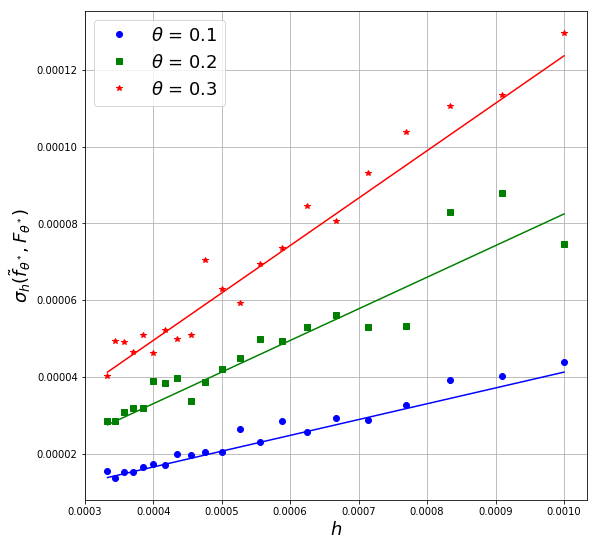

In [60]:
plt.figure(figsize=(9, 9))
scale_coefficient = 0.05 * np.sqrt(np.pi / 2)
plt.plot(h_array, first_error_array.flatten(), 'bo', label=r'$\theta$ = 0.1')
plt.plot(h_array, second_error_array.flatten(), 'gs', label=r'$\theta$ = 0.2')
plt.plot(h_array, third_error_array.flatten(), 'r*', label=r'$\theta$ = 0.3')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.1 * h_array * scale_coefficient, 'b')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.2 * h_array * scale_coefficient, 'g')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.3 * h_array * scale_coefficient, 'r')
plt.grid(True)
plt.xlabel(r'$h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.savefig('gp.png', dpi=500)

In [53]:
sample_size_array = np.array([int(x) for x in np.linspace(1000, 3000, 21)])
coefficient = 10
h_array = 1. / (sample_size_array) * coefficient

variance = np.sqrt(np.pi / 2)
theta_estimate_1 = 0.1
theta_estimate_2 = 0.2
theta_estimate_3 = 0.3
noise_variance = 1e-16

kernel_1 = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_1)
kernel_2 = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_2)
kernel_3 = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_3)

repeat_num = 10
error_array = np.zeros((3, sample_size_array.shape[0], repeat_num))
t0 = time.time()
t00 = t0
for index, sample_size in enumerate(sample_size_array):
    sample_size += 1
    for k in range(repeat_num):
        error_array[0, index, k] = prediction_left(kernel_1, kernel_1, sample_size, noise_variance=noise_variance)
        error_array[1, index, k] = prediction_left(kernel_2, kernel_2, sample_size, noise_variance=noise_variance)
        error_array[2, index, k] = prediction_left(kernel_3, kernel_3, sample_size, noise_variance=noise_variance)
    t1 = time.time()
    print(index, t1 - t0)
    t0 = t1

time.time() - t00

0 3.8321735858917236
1 5.0584516525268555
2 4.969027042388916
3 5.03138279914856
4 5.863597631454468
5 8.909698247909546
6 8.365249156951904
7 8.437442302703857
8 9.803075790405273
9 11.444440364837646
10 12.82310700416565
11 14.564738512039185
12 16.132911920547485
13 18.62052607536316
14 20.395248413085938
15 22.720433950424194
16 25.854769229888916
17 29.050268411636353
18 31.249117612838745
19 37.86070370674133
20 36.277230739593506


337.2635941505432

In [44]:
error_array

array([[[ 0.00034654,  0.00040036,  0.00039351,  0.00046725,  0.00042148,
          0.00036361,  0.00049543,  0.00039233,  0.00039581,  0.0003924 ],
        [ 0.00043594,  0.00043499,  0.00037018,  0.0004001 ,  0.00037426,
          0.00034898,  0.00031346,  0.00039283,  0.00039826,  0.00044024],
        [ 0.00036799,  0.00029891,  0.00034259,  0.0003865 ,  0.00035745,
          0.00029755,  0.00037089,  0.00040268,  0.00033248,  0.00033747],
        [ 0.0003475 ,  0.00028818,  0.00029633,  0.00026017,  0.00029961,
          0.00036667,  0.00031703,  0.00030455,  0.00030255,  0.0002755 ],
        [ 0.00027772,  0.00028027,  0.00030624,  0.00029127,  0.00028702,
          0.00030059,  0.00035266,  0.00029306,  0.0003122 ,  0.00026005],
        [ 0.00026276,  0.00025749,  0.00027216,  0.00028127,  0.00030848,
          0.00029408,  0.00026024,  0.00029183,  0.00031558,  0.00030193],
        [ 0.000238  ,  0.00027425,  0.00025622,  0.00022774,  0.00022999,
          0.00025167,  0.0002836

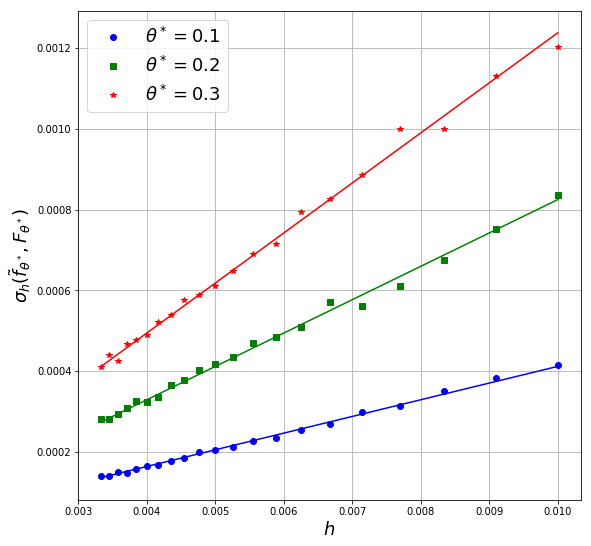

In [54]:
plt.figure(figsize=(9, 9))
scale_coefficient = 0.05 * np.sqrt(np.pi / 2)
plt.plot(h_array, np.mean(error_array[0], axis=1), 'bo', label=r'$\theta^* = 0.1$')
plt.plot(h_array, np.mean(error_array[1], axis=1), 'gs', label=r'$\theta^* = 0.2$')
plt.plot(h_array, np.mean(error_array[2], axis=1), 'r*', label=r'$\theta^* = 0.3$')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.1 * h_array * scale_coefficient, 'b')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.2 * h_array * scale_coefficient, 'g')
plt.plot(h_array, 2 / 3. * np.pi ** 2 * 0.3 * h_array * scale_coefficient, 'r')
plt.legend(loc='upper left', fontsize=18)
plt.xlabel(r'$h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.grid(True)
plt.savefig('choletski.png', dpi=500)

In [10]:
sample_size_array = np.array([int(x) for x in np.linspace(1000, 4000, 11)])
coefficient = 10
h_array = 1. / (sample_size_array) * coefficient

variance = np.sqrt(np.pi / 2)
theta_estimate_1 = 0.1
theta_estimate_2 = 1
theta_estimate_3 = 10
noise_variance = 1e-16

kernel_1 = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_1)
kernel_2 = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_2)
kernel_3 = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_3)

repeat_num = 20
error_array = np.zeros((3, sample_size_array.shape[0], repeat_num))
t0 = time.time()
t00 = t0
for index, sample_size in enumerate(sample_size_array):
    sample_size += 1
    for k in range(repeat_num):
        error_array[0, index, k] = prediction_left(kernel_1, kernel_1, sample_size, noise_variance=noise_variance)
        error_array[1, index, k] = prediction_left(kernel_1, kernel_2, sample_size, noise_variance=noise_variance)
        error_array[2, index, k] = prediction_left(kernel_1, kernel_3, sample_size, noise_variance=noise_variance)
    t1 = time.time()
    print(index, t1 - t0)
    t0 = t1

time.time() - t00

0 6.587520360946655
1 12.09538745880127
2 18.20341658592224
3 26.885510444641113
4 37.278679847717285
5 50.98364543914795
6 61.77831983566284
7 76.92260098457336
8 94.02308535575867
9 114.99185872077942
10 135.08029103279114


634.830316066742

In [28]:
h_array

array([ 0.001     ,  0.00076923,  0.000625  ,  0.00052632,  0.00045455,
        0.0004    ,  0.00035714,  0.00032258,  0.00029412,  0.00027027,
        0.00025   ])

In [11]:
table_1 = pd.DataFrame()
table_1["h"] = h_array
for t, tau in enumerate([0.1, 1, 10]):
    table_1["Theta_"+str(tau)+"_mean"] = np.mean(error_array[t], axis=1)
    table_1["Theta_"+str(tau)+"_std"]  = np.std(error_array[t], axis=1)
table_1

,h,Theta_0.1_mean,Theta_0.1_std,Theta_1_mean,Theta_1_std,Theta_10_mean,Theta_10_std
0,0.010000,0.000419,0.000054,0.000410,0.000034,0.000408,0.000033
1,0.007692,0.000322,0.000026,0.000322,0.000028,0.000327,0.000025
2,0.006250,0.000258,0.000014,0.000257,0.000021,0.000263,0.000019
3,0.005263,0.000217,0.000012,0.000224,0.000011,0.000217,0.000014
4,0.004545,0.000189,0.000011,0.000186,0.000012,0.000191,0.000011
5,0.004000,0.000163,0.000005,0.000166,0.000010,0.000171,0.000009
6,0.003571,0.000146,0.000007,0.000148,0.000008,0.000147,0.000008
7,0.003226,0.000135,0.000005,0.000135,0.000007,0.000133,0.000006
8,0.002941,0.000122,0.000006,0.000121,0.000008,0.000122,0.000004
9,0.002703,0.000111,0.000003,0.000112,0.000007,0.000112,0.000005


In [12]:
sample_size_array = np.array([int(x) for x in np.linspace(1000, 4000, 11)])
coefficient = 10
h_array = 1. / (sample_size_array) * coefficient

variance = np.sqrt(np.pi / 2)
theta_estimate_1 = 0.1
theta_estimate_2 = 1
theta_estimate_3 = 10
noise_variance = 1e-16

kernel_1 = GPy.kern.Matern32(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_1)
kernel_2 = GPy.kern.Matern32(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_2)
kernel_3 = GPy.kern.Matern32(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_3)

repeat_num = 20
error_array = np.zeros((3, sample_size_array.shape[0], repeat_num))
t0 = time.time()
t00 = t0
for index, sample_size in enumerate(sample_size_array):
    sample_size += 1
    for k in range(repeat_num):
        error_array[0, index, k] = prediction_left(kernel_1, kernel_1, sample_size, noise_variance=noise_variance)
        error_array[1, index, k] = prediction_left(kernel_1, kernel_2, sample_size, noise_variance=noise_variance)
        error_array[2, index, k] = prediction_left(kernel_1, kernel_3, sample_size, noise_variance=noise_variance)
    t1 = time.time()
    print(index, t1 - t0)
    t0 = t1

time.time() - t00

0 8.216855764389038
1 13.729516744613647
2 20.61182427406311
3 30.299591064453125
4 39.23736548423767
5 47.55448627471924
6 66.25121760368347
7 84.68825626373291
8 114.21307349205017
9 122.72134804725647
10 146.41400718688965


693.9385457038879

In [29]:
error_array

array([[[  1.18511925e-06,   1.37637677e-06,   1.04916217e-06,
           1.63603719e-06,   8.57394329e-07,   9.09310397e-07,
           1.53205069e-06,   1.02641937e-06,   1.14584764e-06,
           1.03558050e-06,   1.04390715e-06,   8.85208525e-07,
           1.14402983e-06,   1.03238219e-06,   9.32807143e-07,
           1.05495968e-06,   1.37679348e-06,   8.78367077e-07,
           8.18942411e-07,   1.04720790e-06],
        [  9.73946230e-07,   1.30709771e-06,   9.69001551e-07,
           8.97218355e-07,   8.36694233e-07,   8.82264545e-07,
           9.21507273e-07,   1.27514279e-06,   1.19359084e-06,
           9.87173390e-07,   7.86047482e-07,   7.75921435e-07,
           1.02440796e-06,   9.37172979e-07,   9.80691410e-07,
           9.82936339e-07,   9.60973663e-07,   1.05888165e-06,
           7.35098189e-07,   7.81221888e-07],
        [  9.66748464e-07,   1.04086927e-06,   8.04748554e-07,
           9.80990644e-07,   9.21396874e-07,   9.90874934e-07,
           8.76940455e-07,

In [13]:
table_2 = pd.DataFrame()
table_2["h"] = h_array
for t, tau in enumerate([0.1, 1, 10]):
    table_2["Theta_"+str(tau)+"_mean"] = np.mean(error_array[t], axis=1)
    table_2["Theta_"+str(tau)+"_std"]  = np.std(error_array[t], axis=1)
table_2

,h,Theta_0.1_mean,Theta_0.1_std,Theta_1_mean,Theta_1_std,Theta_10_mean,Theta_10_std
0,0.010000,1.395990e-08,1.089982e-09,1.670440e-08,1.217377e-09,4.980656e-08,4.177657e-08
1,0.007692,1.317649e-08,7.376865e-10,1.658997e-08,1.168685e-09,2.292047e-08,7.678083e-09
2,0.006250,1.262490e-08,6.659394e-10,1.643679e-08,9.741368e-10,1.786432e-08,1.841703e-09
3,0.005263,1.229328e-08,5.516365e-10,1.666752e-08,9.392961e-10,1.758394e-08,1.289567e-09
4,0.004545,1.202811e-08,5.959924e-10,1.585811e-08,7.817118e-10,1.717038e-08,1.126372e-09
5,0.004000,1.180608e-08,4.987187e-10,1.609391e-08,5.028754e-10,1.702005e-08,8.121154e-10
6,0.003571,1.178941e-08,5.531107e-10,1.548590e-08,8.411517e-10,1.677822e-08,1.039060e-09
7,0.003226,1.163830e-08,4.860778e-10,1.535407e-08,6.288237e-10,1.701786e-08,9.566657e-10
8,0.002941,1.137258e-08,3.970791e-10,1.521641e-08,7.160072e-10,1.652769e-08,6.662960e-10
9,0.002703,1.142619e-08,3.350472e-10,1.495893e-08,5.375031e-10,1.704364e-08,6.698361e-10


In [14]:
sample_size_array = np.array([int(x) for x in np.linspace(1000, 4000, 11)])
coefficient = 10
h_array = 1. / (sample_size_array) * coefficient

variance = np.sqrt(np.pi / 2)
theta_estimate_1 = 0.1
theta_estimate_2 = 1
theta_estimate_3 = 10
noise_variance = 1e-16

kernel_1 = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_1)
kernel_2 = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_2)
kernel_3 = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=1. / theta_estimate_3)

repeat_num = 20
error_array = np.zeros((3, sample_size_array.shape[0], repeat_num))
t0 = time.time()
t00 = t0
for index, sample_size in enumerate(sample_size_array):
    sample_size += 1
    for k in range(repeat_num):
        error_array[0, index, k] = prediction_left(kernel_1, kernel_1, sample_size, noise_variance=noise_variance)
        error_array[1, index, k] = prediction_left(kernel_1, kernel_2, sample_size, noise_variance=noise_variance)
        error_array[2, index, k] = prediction_left(kernel_1, kernel_3, sample_size, noise_variance=noise_variance)
    t1 = time.time()
    print(index, t1 - t0)
    t0 = t1

time.time() - t00

0 7.4658989906311035
1 12.232534408569336
2 18.80802631378174
3 28.150248050689697
4 37.38243126869202
5 49.78050780296326
6 63.71246337890625
7 78.73999428749084
8 95.56636810302734
9 115.50239634513855
10 120.20164132118225


627.5435128211975

In [15]:
table_3 = pd.DataFrame()
table_3["h"] = h_array
for t, tau in enumerate([0.1, 1, 10]):
    table_3["Theta_"+str(tau)+"_mean"] = np.mean(error_array[t], axis=1)
    table_3["Theta_"+str(tau)+"_std"]  = np.std(error_array[t], axis=1)
table_3

,h,Theta_0.1_mean,Theta_0.1_std,Theta_1_mean,Theta_1_std,Theta_10_mean,Theta_10_std
0,0.010000,1.040131e-08,4.534081e-10,1.051047e-08,6.294801e-10,1.182199e-08,8.169415e-10
1,0.007692,1.024960e-08,2.707474e-10,1.039320e-08,4.318200e-10,1.130818e-08,6.066931e-10
2,0.006250,1.001477e-08,2.427559e-10,1.017673e-08,4.051410e-10,1.130709e-08,5.375178e-10
3,0.005263,1.012382e-08,3.167382e-10,1.019294e-08,2.894326e-10,1.110515e-08,2.996867e-10
4,0.004545,1.020557e-08,3.487929e-10,1.034808e-08,3.749184e-10,1.080272e-08,3.782447e-10
5,0.004000,1.009696e-08,3.137355e-10,1.023044e-08,2.889172e-10,1.078616e-08,4.409454e-10
6,0.003571,1.012577e-08,2.819953e-10,1.021796e-08,1.733971e-10,1.068428e-08,3.432870e-10
7,0.003226,1.005368e-08,2.785492e-10,1.021280e-08,3.271387e-10,1.059845e-08,2.824919e-10
8,0.002941,1.007751e-08,2.792960e-10,1.015050e-08,3.141595e-10,1.062112e-08,3.150462e-10
9,0.002703,1.015471e-08,2.046625e-10,1.017686e-08,3.243028e-10,1.053724e-08,3.020421e-10


In [16]:
table_1.to_csv("table_exp.csv")
table_2.to_csv("table_mat32.csv")
table_3.to_csv("table_rbf.csv")

In [69]:
sample_size_array = np.array([int(x) for x in np.linspace(1000, 4000, 11)])
coefficient = 10
h_array = 1. / (sample_size_array) * coefficient

variance = np.sqrt(np.pi / 2)
noise_variance = 1e-16

kernel_0 = GPy.kern.Matern32(input_dim=1, variance=variance, lengthscale=1.)
kernel_1 = GPy.kern.Matern52(input_dim=1, variance=variance, lengthscale=1.)
kernel_2 = GPy.kern.Exponential(input_dim=1, variance=variance, lengthscale=1.)
kernel_3 = GPy.kern.RBF(input_dim=1, variance=variance, lengthscale=1.)

repeat_num = 20
error_array = np.zeros((4, sample_size_array.shape[0], repeat_num))
t0 = time.time()
t00 = t0
for index, sample_size in enumerate(sample_size_array):
    sample_size += 1
    for k in range(repeat_num):
        error_array[0, index, k] = prediction_left(kernel_0, kernel_0, sample_size, noise_variance=noise_variance)
        error_array[1, index, k] = prediction_left(kernel_0, kernel_1, sample_size, noise_variance=noise_variance)
        error_array[2, index, k] = prediction_left(kernel_0, kernel_2, sample_size, noise_variance=noise_variance)
        error_array[3, index, k] = prediction_left(kernel_0, kernel_3, sample_size, noise_variance=noise_variance)
    t1 = time.time()
    print(index, t1 - t0)
    t0 = t1

time.time() - t00

0 8.583527326583862
1 16.18009662628174
2 21.16930651664734
3 31.383475303649902
4 44.97863578796387
5 64.80537104606628
6 110.98408508300781
7 110.35652947425842
8 128.90770649909973
9 172.53504729270935
10 208.06635546684265


917.9506378173828

In [70]:
table_4 = pd.DataFrame()
table_4["h"] = h_array
for t, name in enumerate(["Matern32", "Matern52", "Exponential", "RBF"]):
    table_4[name+"_mean"] = np.mean(error_array[t], axis=1)
    table_4[name+"_std"]  = np.std(error_array[t], axis=1)
table_4.to_csv("table_mix.csv")
table_4

,h,Matern32_mean,Matern32_std,Matern52_mean,Matern52_std,Exponential_mean,Exponential_std,RBF_mean,RBF_std
0,0.010000,1.708430e-07,2.092855e-08,1.144022e-06,2.087054e-07,2.982910e-07,3.630493e-08,0.000651,0.000451
1,0.007692,8.368552e-08,8.075274e-09,1.028762e-06,1.959096e-07,1.446047e-07,1.396781e-08,0.000500,0.000356
2,0.006250,5.180043e-08,5.177456e-09,8.683684e-07,1.285285e-07,8.606706e-08,6.811627e-09,0.000790,0.000527
3,0.005263,3.831769e-08,3.853424e-09,8.217764e-07,1.260374e-07,5.697325e-08,3.675611e-09,0.000662,0.000397
4,0.004545,3.057691e-08,1.645449e-09,7.560825e-07,1.484387e-07,4.142201e-08,2.654649e-09,0.000640,0.000456
5,0.004000,2.598136e-08,1.111829e-09,7.328153e-07,8.988430e-08,3.304228e-08,2.068961e-09,0.000540,0.000498
6,0.003571,2.299362e-08,1.089571e-09,6.533156e-07,8.074099e-08,2.747393e-08,1.062883e-09,0.000458,0.000263
7,0.003226,2.138207e-08,1.273621e-09,6.535984e-07,1.006117e-07,2.443475e-08,9.643956e-10,0.000534,0.000277
8,0.002941,1.971495e-08,7.438605e-10,6.109961e-07,9.130182e-08,2.194350e-08,7.703840e-10,0.000548,0.000267
9,0.002703,1.866436e-08,6.333383e-10,5.931429e-07,9.824035e-08,2.050185e-08,9.714086e-10,0.000535,0.000248


In [19]:
import scipy

In [20]:
scipy.stats.ranksums(table_1.Theta_1_mean, table_1.Theta_10_mean)

RanksumsResult(statistic=-0.032832505387027963, pvalue=0.97380815662885178)

In [21]:
scipy.stats.ranksums(table_1.Theta_1_std, table_1.Theta_10_std)

RanksumsResult(statistic=0.62381760235353134, pvalue=0.53274737824469043)

In [22]:
tables = ["Exponential", "Matern", "RBF"]
for t, table in enumerate([table_1, table_2, table_3]):
    print("table:", tables[t])
    print("Theta = 0.1 vs Theta = 1:\n", scipy.stats.ranksums(table["Theta_0.1_mean"], table["Theta_1_mean"]))
    print("Theta = 0.1 vs Theta = 10:\n", scipy.stats.ranksums(table["Theta_0.1_mean"], table["Theta_10_mean"]))
    print("Theta = 1 vs Theta = 10:\n", scipy.stats.ranksums(table["Theta_1_mean"], table["Theta_10_mean"]))
#     print(scipy.stats.ranksums(table["Theta_0.1_std"], table["Theta_1_std"]))
#     print(scipy.stats.ranksums(table["Theta_0.1_std"], table["Theta_10_std"]))
#     print(scipy.stats.ranksums(table["Theta_1_std"], table["Theta_10_std"]))

table: Exponential
Theta = 0.1 vs Theta = 1:
 RanksumsResult(statistic=0.032832505387027963, pvalue=0.97380815662885178)
Theta = 0.1 vs Theta = 10:
 RanksumsResult(statistic=-0.16416252693513983, pvalue=0.86960320001694202)
Theta = 1 vs Theta = 10:
 RanksumsResult(statistic=-0.032832505387027963, pvalue=0.97380815662885178)
table: Matern
Theta = 0.1 vs Theta = 1:
 RanksumsResult(statistic=-3.9727331518303837, pvalue=7.1052632886001551e-05)
Theta = 0.1 vs Theta = 10:
 RanksumsResult(statistic=-3.9727331518303837, pvalue=7.1052632886001551e-05)
Theta = 1 vs Theta = 10:
 RanksumsResult(statistic=-3.5787430871860479, pvalue=0.00034525065117902917)
table: RBF
Theta = 0.1 vs Theta = 1:
 RanksumsResult(statistic=-2.4624379040270972, pvalue=0.013799606617843806)
Theta = 0.1 vs Theta = 10:
 RanksumsResult(statistic=-3.9727331518303837, pvalue=7.1052632886001551e-05)
Theta = 1 vs Theta = 10:
 RanksumsResult(statistic=-3.9070681410563277, pvalue=9.342281369516416e-05)


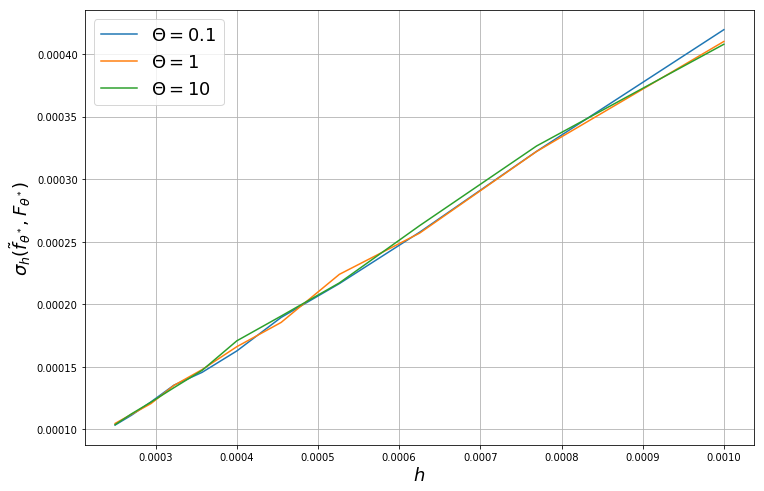

In [40]:
h_array = 1./ np.linspace(1000, 4000, 11)
plt.figure(figsize=(12, 8))
plt.plot(h_array, table_1["Theta_0.1_mean"], label=r"$\Theta = 0.1$")
plt.plot(h_array, table_1["Theta_1_mean"], label=r"$\Theta = 1$")
plt.plot(h_array, table_1["Theta_10_mean"], label=r"$\Theta = 10$")
#plt.title("Exponential", fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.xlabel(r'$h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.grid(True)
plt.savefig('Exponential_theta.png', dpi = 500)

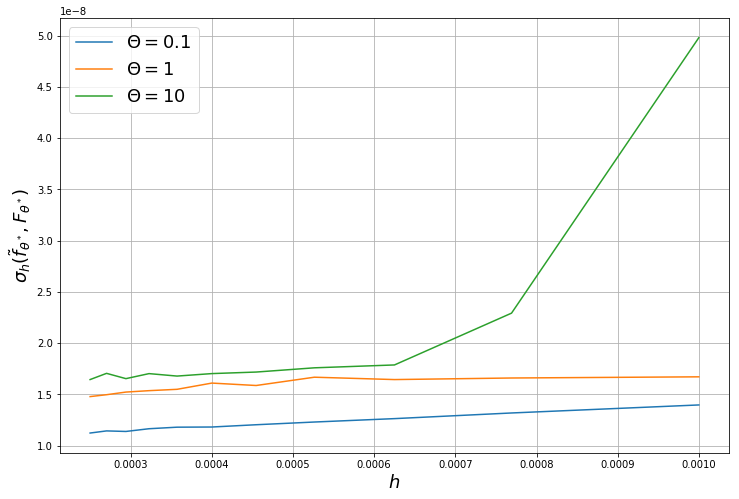

In [39]:
plt.figure(figsize=(12, 8))
plt.plot(h_array, table_2["Theta_0.1_mean"], label=r"$\Theta = 0.1$")
plt.plot(h_array, table_2["Theta_1_mean"], label=r"$\Theta = 1$")
plt.plot(h_array, table_2["Theta_10_mean"], label=r"$\Theta = 10$")
#plt.title(r"Matern $\nu=\frac{3}{2}$", fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.xlabel(r'$h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.grid(True)
plt.savefig('Matern_theta.png', dpi = 500)

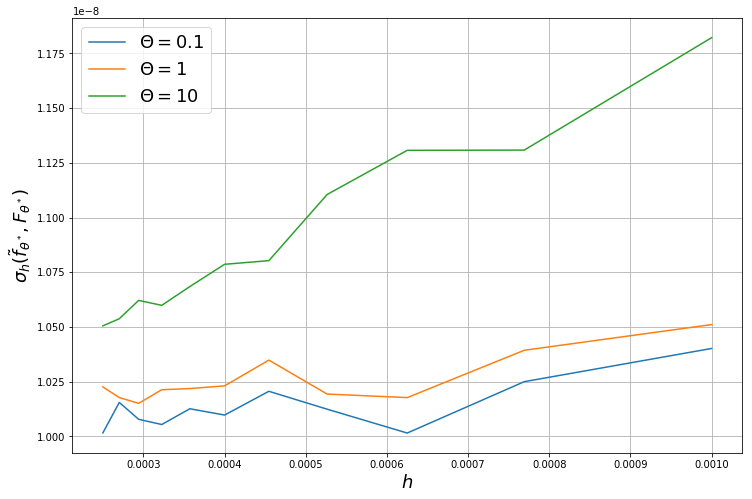

In [38]:
plt.figure(figsize=(12, 8))
plt.plot(h_array, table_3["Theta_0.1_mean"], label=r"$\Theta = 0.1$")
plt.plot(h_array, table_3["Theta_1_mean"], label=r"$\Theta = 1$")
plt.plot(h_array, table_3["Theta_10_mean"], label=r"$\Theta = 10$")
#plt.title("RBF", fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.xlabel(r'$h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.grid(True)
plt.savefig('RBF_theta.png', dpi = 500)

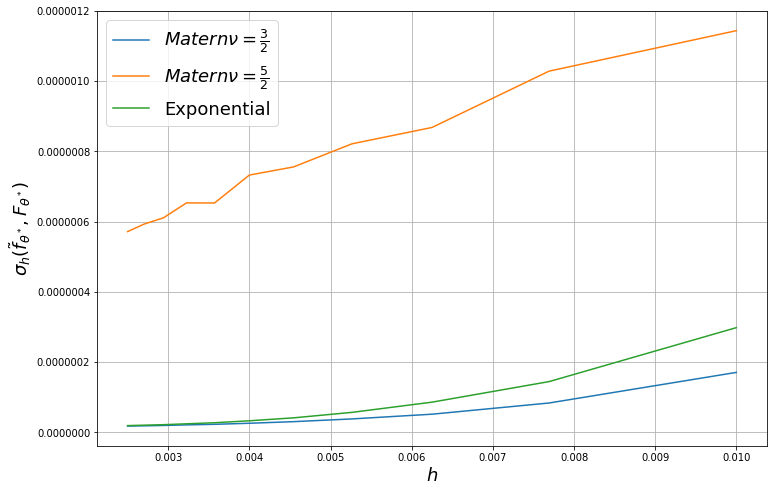

In [72]:
plt.figure(figsize=(12, 8))
plt.plot(h_array, table_4["Matern32_mean"], label=r"$Matern \nu=\frac{3}{2}$")
plt.plot(h_array, table_4["Matern52_mean"], label=r"$Matern \nu=\frac{5}{2}$")
plt.plot(h_array, table_4["Exponential_mean"], label=r"Exponential")
#plt.title(r"Matern $\nu=\frac{3}{2}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.xlabel(r'$h$', fontsize=18)
plt.ylabel(r'$\sigma_h(\tilde{f}_{\theta^*}, F_{\theta^*})$', fontsize=18)
plt.grid(True)
plt.savefig('Matern52_32_Exponential.png', dpi = 500)